In [1]:
#Import relevant python packages
import os
import pandas as pd
import time
import numpy as np
import random
import requests
import tracemalloc
from sklearn.decomposition import PCA
from tqdm import tqdm
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
import random
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import BallTree
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from itertools import combinations
from collections import defaultdict
import gensim
import networkx as nx
from community import community_louvain

## **Goodreads Dataset Procurement and Processing**
### Scraping and collecting data

In [2]:
class GoodreadsDataset:
    
    def __init__(self, save_path: Path, num_pages: int):
        self.save_path = save_path
        self.num_pages = num_pages
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"
        }
        self.home_url = "https://www.goodreads.com"
        self.base_url = "https://www.goodreads.com/list/show/1.Best_Books_Ever?page="
        self.books_data = []

    @staticmethod
    def retrieve_genres(headers: dict, book_url: str):
        # Make a request to fetch the book page for the provided book url.
        response = requests.get(url=book_url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        # Identify genres using the HTML structure belonging to the genre category.
        genres = soup.select('a[href*="/genres/"]')
        return genres
    
    @staticmethod
    def to_csv(books_data: list, file_name: str):
        df = pd.DataFrame(books_data)
        df.to_csv(file_name, index=False)
        
    @staticmethod
    def scrape_bookpage(books_data: list, headers: dict, base_url: str, home_url: str, page: int):
        # Formulate bookpage url. 
        url = base_url + str(page)
        # Make a request to fetch the page content.
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        # Find all books within the page content. 
        books = soup.find_all('tr', itemtype="http://schema.org/Book")
        for book in books:
            try:
                title = book.find('a', class_="bookTitle")
                author = book.find('a', class_="authorName")
                rating = book.find('span', class_="minirating")
                book_url = home_url + title['href']
                genres = GoodreadsDataset.retrieve_genres(headers, book_url)
                # Remove leading and trailing whitespaces.
                title = title.text.strip()
                author = author.text.strip()
                rating = rating.text.strip()[:4]
                genres = [genre.text.strip() for genre in genres]
                # Construct dictionary to store fetched book data. 
                book_data = {
                    'Title': title,
                    'Author': author,
                    'Rating': rating,
                    'Genres': genres
                }
                books_data.append(book_data)
                # Implement a request delay, to ensure continous access to scraping API.
                time.sleep(2)
            except (AttributeError, ValueError):
                continue
        
        return books_data
    
    def main(self):

        filename = "goodreads_dataset.csv"
        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)

        filepath = os.path.join(self.save_path, filename)
        
        if not os.path.exists(filepath):
            for page in range(self.num_pages):
                print(f"Fetching books metadata from page {page}")
                books_data = self.scrape_bookpage(self.books_data, self.headers, self.base_url, self.home_url, page)
                self.books_data.extend(books_data)
                self.to_csv(self.books_data, filepath)
        else:
            print(f"Dataset CSV file already exists.")

In [3]:
filepath = os.path.join("./data", "books_1.Best_Books_Ever.csv")

if not os.path.exists(filepath):
    dataset = GoodreadsDataset("./data", 100)
    dataset.main()

dataset_df = pd.read_csv(filepath)

if filepath == os.path.join("./data", "books_1.Best_Books_Ever.csv"):
    dataset_df = dataset_df.rename(columns={
    'title': 'Title',
    'author': 'Author',
    'rating': 'Rating',
    'genres': 'Genres'
    })
    dataset_df = dataset_df[['Title', 'Author', 'Rating', 'Genres']]

In [4]:
dataset_df.head(10)

,Title,Author,Rating,Genres
0,The Hunger Games,Suzanne Collins,4.33,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas..."
1,Harry Potter and the Order of the Phoenix,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',..."
2,To Kill a Mockingbird,Harper Lee,4.28,"['Classics', 'Fiction', 'Historical Fiction', ..."
3,Pride and Prejudice,"Jane Austen, Anna Quindlen (Introduction)",4.26,"['Classics', 'Fiction', 'Romance', 'Historical..."
4,Twilight,Stephenie Meyer,3.60,"['Young Adult', 'Fantasy', 'Romance', 'Vampire..."
5,The Book Thief,Markus Zusak (Goodreads Author),4.37,"['Historical Fiction', 'Fiction', 'Young Adult..."
6,Animal Farm,"George Orwell, Russell Baker (Preface), C.M. W...",3.95,"['Classics', 'Fiction', 'Dystopia', 'Fantasy',..."
7,The Chronicles of Narnia,"C.S. Lewis, Pauline Baynes (Illustrator)",4.26,"['Fantasy', 'Classics', 'Fiction', 'Young Adul..."
8,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,J.R.R. Tolkien,4.60,"['Fantasy', 'Fiction', 'Classics', 'Adventure'..."
9,Gone with the Wind,Margaret Mitchell,4.30,"['Classics', 'Historical Fiction', 'Fiction', ..."


In [5]:
# number of rows with unique "Title"
dataset_df['Title'].nunique()

49927

### Cleaning and preprocessing of data

In [6]:
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from tqdm.auto import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split

class DataPreprocessor:
    def __init__(self, df):
        self.df = df.copy() 
        self.train_data = None
        self.test_data = None
        self.total_steps = 5 
        self.current_step = 0
    
    def _update_progress(self, description):
        """Update the overall progress and display current step"""
        self.current_step += 1
        print(f"\nStep {self.current_step}/{self.total_steps}: {description}")
    
    def clean_data(self):
        print("Starting data preprocessing pipeline...")
        self._update_progress("Checking initial data")
        print(f"Initial shape: {self.df.shape}")
        
        # Remove rows with empty genres
        self._update_progress("Removing empty genres")
        self.df = self.df.dropna(subset=['Genres'])
        print(f"Shape after removing empty genres: {self.df.shape}")
        
        # Clean and convert ratings
        self._update_progress("Cleaning ratings")
        self._clean_ratings()
        print(f"Shape after cleaning ratings: {self.df.shape}")
        
        # Filter non-English titles
        self._update_progress("Filtering non-English titles")
        self._filter_english_titles()
        print(f"Shape after filtering non-English titles: {self.df.shape}")
        
        # Convert genres and final cleanup
        self._update_progress("Processing genres and final cleanup")
        # Convert genres from string to list if they're strings
        if self.df['Genres'].dtype == 'object':
            tqdm.pandas(desc="Converting genres to lists")
            self.df['Genres'] = self.df['Genres'].progress_apply(self._convert_genres_to_list)
        
        # Remove books with empty genre lists
        self.df = self.df[self.df['Genres'].map(len) > 0]
        print(f"Final shape: {self.df.shape}")
        
        print("\nData preprocessing completed!")
        return self.df
    
    def _filter_english_titles(self):
        def is_english(text):
            try:
                return detect(str(text)) == 'en'
            except LangDetectException:
                return False
        
        # Create a progress bar for language detection
        tqdm.pandas(desc="Detecting languages")
        english_mask = self.df['Title'].progress_apply(is_english)
        
        # Store the number of non-English titles for reporting
        non_english_count = (~english_mask).sum()
        
        # Apply the filter
        self.df = self.df[english_mask]
        print(f"Removed {non_english_count} non-English titles")
    
    def _clean_ratings(self):
        def convert_rating(rating):
            try:
                if isinstance(rating, str):
                    rating = ''.join(c for c in rating if c.isdigit() or c == '.')
                return float(rating)
            except:
                return None
        
        # Convert ratings with progress bar
        tqdm.pandas(desc="Converting ratings")
        self.df['Rating'] = self.df['Rating'].progress_apply(convert_rating)
        
        # Remove rows with invalid ratings
        self.df = self.df.dropna(subset=['Rating'])
        
        # Ensure ratings are within valid range (0-5)
        self.df = self.df[self.df['Rating'].between(0, 5)]
    
    def _convert_genres_to_list(self, genres_str):
        if isinstance(genres_str, list):
            return genres_str
        try:
            genres_str = genres_str.strip('[]')
            genres = [g.strip().strip("'").strip('"') for g in genres_str.split(',')]
            return [g for g in genres if g]  # Remove empty strings
        except:
            return []
    
    def create_train_test_split(self, test_size=0.2, random_state=42):
        print("\nCreating train-test split...")
        self.train_data, self.test_data = train_test_split(
            self.df,
            test_size=test_size,
            random_state=random_state
        )
        
        print(f"Training set size: {len(self.train_data)}")
        print(f"Test set size: {len(self.test_data)}")
        
        return self.train_data, self.test_data
    
    def get_genre_statistics(self):
        print("\nCalculating genre statistics...")
        all_genres = []
        for genres in tqdm(self.df['Genres'], desc="Analyzing genres"):
            all_genres.extend(genres)
        
        genre_counts = pd.Series(all_genres).value_counts()
        
        print("\nGenre Statistics:")
        print(f"Total unique genres: {len(genre_counts)}")
        print("\nTop 10 most common genres:")
        print(genre_counts.head(10))
        
        return genre_counts

/Users/markandrawes/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Apply preprocessing
preprocessor = DataPreprocessor(dataset_df)
cleaned_df = preprocessor.clean_data()

# Create train-test split
train_data, test_data = preprocessor.create_train_test_split()

# Display data info
print("\nDataset info after cleaning:")
print(cleaned_df.info())

# Display some statistics
print("\nRating statistics:")
print(cleaned_df['Rating'].describe())

# Get genre statistics
genre_stats = preprocessor.get_genre_statistics()

# Create train-test split
train_data, test_data = preprocessor.create_train_test_split()

# Display sample of cleaned data
print("\nSample of cleaned data:")
print(cleaned_df.head(5))

Starting data preprocessing pipeline...

Step 1/5: Checking initial data
Initial shape: (52478, 4)

Step 2/5: Removing empty genres
Shape after removing empty genres: (52478, 4)

Step 3/5: Cleaning ratings


Converting ratings: 100%|██████████| 52478/52478 [00:00<00:00, 1759405.66it/s]


Shape after cleaning ratings: (52478, 4)

Step 4/5: Filtering non-English titles


Detecting languages: 100%|██████████| 52478/52478 [02:40<00:00, 327.58it/s]


Removed 17390 non-English titles
Shape after filtering non-English titles: (35088, 4)

Step 5/5: Processing genres and final cleanup


Converting genres to lists: 100%|██████████| 35088/35088 [00:00<00:00, 213748.88it/s]


Final shape: (32092, 4)

Data preprocessing completed!

Creating train-test split...
Training set size: 25673
Test set size: 6419

Dataset info after cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 32092 entries, 1 to 52477
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Title   32092 non-null  object 
 1   Author  32092 non-null  object 
 2   Rating  32092 non-null  float64
 3   Genres  32092 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB
None

Rating statistics:
count    32092.000000
mean         4.014483
std          0.287520
min          1.900000
25%          3.830000
50%          4.030000
75%          4.210000
max          5.000000
Name: Rating, dtype: float64

Calculating genre statistics...


Analyzing genres: 100%|██████████| 32092/32092 [00:00<00:00, 6021185.59it/s]



Genre Statistics:
Total unique genres: 951

Top 10 most common genres:
Fiction               20874
Fantasy               10030
Romance                9639
Young Adult            7752
Nonfiction             6742
Contemporary           6716
Adult                  5670
Audiobook              5361
Historical Fiction     5295
Mystery                5281
Name: count, dtype: int64

Creating train-test split...
Training set size: 25673
Test set size: 6419

Sample of cleaned data:
                                       Title  \
1  Harry Potter and the Order of the Phoenix   
2                      To Kill a Mockingbird   
4                                   Twilight   
5                             The Book Thief   
7                   The Chronicles of Narnia   

                                      Author  Rating  \
1  J.K. Rowling, Mary GrandPré (Illustrator)    4.50   
2                                 Harper Lee    4.28   
4                            Stephenie Meyer    3.60   
5        

## **Frequent itemset algorithms**

### Apriori Algorithm

In [8]:
class Apriori:
    def __init__(self, df: pd.DataFrame, min_support: float):
        self.df = df
        self.min_support = min_support
        self.frequent_itemsets = []
        self.genres_df = self.df['Genres']
        self.df = self.one_hot_encode(self.genres_df)

    @staticmethod
    def one_hot_encode(genres_df: pd.DataFrame):
        one_hot_encoded = genres_df.apply(lambda x: pd.Series(1, index=x)).fillna(0)
        return one_hot_encoded

    @staticmethod
    def retrieve_singletons(df: pd.DataFrame):
        return df.sum(axis=0).to_dict()

    @staticmethod
    def set_of_candidates(itemsets: list[tuple], k: int):
        candidates = set()
        for i in range(len(itemsets)):
            for j in range(i + 1, len(itemsets)):
                ith_itemset = itemsets[i]
                jth_itemset = itemsets[j]
                candidate = tuple(sorted(set(ith_itemset).union(set(jth_itemset))))
                if len(candidate) == k:
                    candidates.add(candidate)
        return list(candidates)

    @staticmethod
    def compute_support(df: pd.DataFrame, itemset: tuple):
        count = df[list(itemset)].all(axis=1).sum() if all(genre in df.columns for genre in itemset) else 0
        support = count / len(df)
        return support
    
    def run_apriori(self, min_confidence: float):

        freq_itemsets = {}
        frequent_1_itemsets = []
    
        # Generate 1-itemsets
        singletons = self.retrieve_singletons(self.df)
        k = 1

        for genre, count in singletons.items():
            support = count / len(self.df)
            if support >= self.min_support:
                self.frequent_itemsets.append({'support': support, 'itemsets': (genre,)})
                frequent_1_itemsets.append((genre,))
        
        freq_itemsets[k] = frequent_1_itemsets
            
        # Generate k-itemsets
        k = 2
        while True:
            candidates = self.set_of_candidates(freq_itemsets[k - 1], k)
            frequent_k_itemsets = []
            frequent_itemsets = []
            for candidate in candidates:
                support = self.compute_support(self.df, candidate)
                if support >= self.min_support:
                    frequent_itemsets.append({'support': support, 'itemsets': (candidate)})
                    frequent_k_itemsets.append(candidate)
            if not frequent_itemsets:
                break
            else:
                freq_itemsets[k] = frequent_k_itemsets
                k += 1
                self.frequent_itemsets.extend(frequent_itemsets)

            

        rules = association_rules(df=pd.DataFrame(self.frequent_itemsets), min_threshold=min_confidence)

        return pd.DataFrame(self.frequent_itemsets), pd.DataFrame(rules)

#### Testing Apriori implementation

In [ ]:
# Initialize the A-Priori class.
apriori_custom = Apriori(train_data, min_support=0.05)

# Perform the A-Priori algorithm to generate frequent itemsets and assocation rules. 
frequent_itemsets_apriori, apriori_rules = apriori_custom.run_apriori(min_confidence=0.7)

# Perform the A-Priori algorithm using another python package.
frequent_itemsets = apriori(apriori_custom.df, min_support=0.05, use_colnames=True)

In [ ]:
print("\nSample of frequent itemsets")
print(frequent_itemsets_apriori.head(5))
print("\nSample of frequent itemsets obtained using mlxtend")
print(frequent_itemsets.head(5))
print("\nSample of association rules")
print(apriori_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(5))


### PCY Algorithm

In [10]:
class PCY:
    def __init__(self, df, min_support, hash_size=10):
        self.df = df
        self.min_support = min_support
        self.hash_size = hash_size
        self.freq_itemsets = []
        self.genres_df = self.df['Genres']
        self.df = self.one_hot_encode(self.genres_df)  # One-hot encode genres for transaction format
        self.transactions = self.df_to_transactions() 
        self.num_transactions = len(self.transactions)

    @staticmethod
    def one_hot_encode(genres_df):
        one_hot_encoded = genres_df.apply(lambda x: pd.Series(1, index=x)).fillna(0)
        return one_hot_encoded

    def df_to_transactions(self):
        # Convert one-hot encoded df to list of transactions
        transactions = []
        for _, row in self.df.iterrows():
            transaction = row.index[row == 1].tolist() 
            transactions.append(transaction)
        return transactions

    def filter_freq_items(self, item_count):
        # Filters based on minimum support threshold
        freq_items = set()
        for item, count in item_count.items():
            if count / self.num_transactions >= self.min_support:
                freq_items.add(item)

        return freq_items
    
    def filter_freq_buckets_to_bitmap(self, hash_table):
        # Converts frequent buckets into a bitmap
        bitmap = np.zeros(self.hash_size, dtype=bool)
        for i, count in enumerate(hash_table):
            if count / self.num_transactions >= self.min_support:
                bitmap[i] = True
        return bitmap
    
    def pass_one(self):
        # Count single items and hash item pairs into buckets
        item_count = defaultdict(int)
        hash_table = np.zeros(self.hash_size, dtype=int)

        for transaction in self.transactions:
            for item in transaction:
                item_count[item] += 1
            for item_pair in combinations(transaction, 2):
                hash_value = hash(frozenset(item_pair)) % self.hash_size  
                hash_table[hash_value] += 1

        return item_count, hash_table

    def pass_two(self, freq_items, bitmap):
        # Count pairs that are both frequent items and hashed to frequent buckets using the bitmap
        pair_count = defaultdict(int)

        for transaction in self.transactions:
            for item_pair in combinations(transaction, 2):
                if item_pair[0] in freq_items and item_pair[1] in freq_items:
                    hash_value = hash(frozenset(item_pair)) % self.hash_size
                    if bitmap[hash_value]:  
                        pair_count[item_pair] += 1

        freq_pairs = {}
        for pair, count in pair_count.items():
            support = count / self.num_transactions
            if support >= self.min_support:
                freq_pairs[pair] = count

        return freq_pairs

    def run_pcy(self, min_confidence: float):
        item_count, hash_table = self.pass_one()

        freq_items = self.filter_freq_items(item_count)

        # Only keep items that meet the minimum support threshold
        filtered_item_count = {item: count for item, count in item_count.items() if item in freq_items}

        bitmap = self.filter_freq_buckets_to_bitmap(hash_table)

        freq_pairs = self.pass_two(freq_items, bitmap)

        for item, count in filtered_item_count.items():
            support = count / self.num_transactions
            if support >= self.min_support:  
                itemset = {'support': support, 'itemsets': (item,)}
                self.freq_itemsets.append(itemset)

        for pair, count in freq_pairs.items():
            support = count / self.num_transactions
            itemset = {'support': support, 'itemsets': set(pair)}
            self.freq_itemsets.append(itemset)

        rules = association_rules(df=pd.DataFrame(self.freq_itemsets), min_threshold=min_confidence)

        return pd.DataFrame(self.freq_itemsets), pd.DataFrame(rules)


#### Testing PCY implementation

In [ ]:
# Initialize the Apriori class.
pcy_custom = PCY(train_data, min_support=0.05)

# Perform the PCY algorithm to generate frequent itemsets and assocation rules. 
frequent_itemsets_pcy, pcy_rules = pcy_custom.run_pcy(min_confidence=0.7)

In [ ]:
print("\nSample of frequent itemsets")
print(frequent_itemsets_pcy.head(5))
print("\nSample of association rules")
print(pcy_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(5))


In [ ]:
# only package of a black-box PCY I could find to compare with but I can't currently get it to run.
# however, it does give the same result as A-Priori

# import pyfim 

# result = pyfim.pcy(df, min_support=2)
# print(result)

#### Quantifying algorithmic performance of A-priori and PCY

In [ ]:
class FrequentItemsPerformance:
    
    def __init__(self, apriori: Apriori, pcy: PCY):
        
        self.apriori = apriori
        self.pcy = pcy

    @staticmethod
    def time(func: callable, *args):
        start = time.time()
        result = func(*args)
        end = time.time()
        time_taken = end - start
        return result, time_taken
    
    @staticmethod
    def patterns(result: tuple):
        frequent_itemsets, rules = result
        return len(frequent_itemsets), len(rules)
    
    @staticmethod
    def memory(func: callable, *args):
        tracemalloc.start()
        result = func(*args)
        size, peak_size = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        return result, peak_size
    
    def compare_algorithms(self, df: pd.DataFrame, min_confidence: float):
        # Intiailize an empty list to store performance results.
        apriori_results = []
        pcy_results = []

        for min_support in tqdm([0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6]):

            # Compute performance metrics using A-priori
            apriori_instance = self.apriori(df, min_support)
            apriori_result, apriori_time = self.time(apriori_instance.run_apriori, min_confidence)
            apriori_instance = self.apriori(df, min_support)
            _, apriori_memory = self.memory(apriori_instance.run_apriori, min_confidence)
            apriori_num_freqitems, apriori_num_rules = self.patterns(apriori_result)

            # Compute performance metrics using PCY
            pcy_instance = self.pcy(df, min_support)
            pcy_result, pcy_time = self.time(pcy_instance.run_pcy, min_confidence)
            pcy_instance = self.pcy(df, min_support)
            _, pcy_memory = self.memory(pcy_instance.run_pcy, min_confidence)
            pcy_num_freqitems, pcy_num_rules = self.patterns(pcy_result)
        
            # Save results
            apriori_results.append({
                "Support": min_support,
                "Time (seconds)": apriori_time,
                "Memory (KB)": apriori_memory / 1024,
                "Frequent Items Found": apriori_num_freqitems,
                "Association rules Found": apriori_num_rules
            })
            pcy_results.append({
                "Support": min_support,
                "Time (seconds)": pcy_time,
                "Memory (KB)": pcy_memory / 1024,
                "Frequent Items Found": pcy_num_freqitems,
                "Association rules Found": pcy_num_rules
            })

        return pd.DataFrame(apriori_results), pd.DataFrame(pcy_results)

In [ ]:
apriori_custom = Apriori
pcy_custom = PCY

performance = FrequentItemsPerformance(apriori_custom, pcy_custom)
apriori_results, pcy_results = performance.compare_algorithms(df=train_data, min_confidence=0.7)

In [ ]:
# Display performance results
apriori_results.head(10)


In [ ]:
# Display performance results
pcy_results.head(10)

## **Clustering**

### K-Means Clustering

In [12]:
class KMeansClustering:
    def __init__(self, df, n_clusters=3, random_state=42):
        self.df = df.copy()
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.genre_to_index = {}
        self.all_genres = []
        self.feature_matrix = None
        self.custom_labels = None
        self.sklearn_labels = None
        self.custom_centroids = None
        self.sklearn_centroids = None
        self.X_pca = None

    def prepare_data(self):
        # Get all unique genres
        all_genres = set()
        for genres in self.df['Genres']:
            all_genres.update(genres)
        self.all_genres = sorted(all_genres)
        
        # Create a mapping from genre to index
        self.genre_to_index = {genre: idx for idx, genre in enumerate(self.all_genres)}
        
        # Convert genres to one-hot encoded vectors
        self.df['Genre_Vector'] = self.df['Genres'].apply(self._genres_to_onehot)
        
        # Scale the Rating feature
        scaler = StandardScaler()
        self.df['Scaled_Rating'] = scaler.fit_transform(self.df[['Rating']])
        
        # Combine Genre_Vector and Scaled_Rating into a single feature vector
        feature_vectors = np.stack(self.df['Genre_Vector'].values)
        ratings = self.df['Scaled_Rating'].values.reshape(-1, 1)
        self.feature_matrix = np.hstack((feature_vectors, ratings))

    def _genres_to_onehot(self, genres_list):
        vector = np.zeros(len(self.all_genres))
        for genre in genres_list:
            idx = self.genre_to_index.get(genre)
            if idx is not None:
                vector[idx] = 1
        return vector

    def fit_custom_kmeans(self):
        # Implement K-means clustering
        np.random.seed(self.random_state)
        initial_centroid_indices = np.random.choice(len(self.feature_matrix), self.n_clusters, replace=False)
        self.custom_centroids = self.feature_matrix[initial_centroid_indices]
        
        for iteration in range(300):  # max_iter=300
            # Assign clusters
            distances = self._compute_distances(self.feature_matrix, self.custom_centroids)
            labels = np.argmin(distances, axis=1)
            # Update centroids
            new_centroids = np.zeros_like(self.custom_centroids)
            for k in range(self.n_clusters):
                cluster_points = self.feature_matrix[labels == k]
                if len(cluster_points) > 0:
                    new_centroids[k] = cluster_points.mean(axis=0)
                else:
                    # Reinitialize centroid if cluster is empty
                    new_centroids[k] = self.feature_matrix[np.random.choice(len(self.feature_matrix))]
            # Check for convergence
            if np.allclose(self.custom_centroids, new_centroids, atol=1e-4):
                break
            self.custom_centroids = new_centroids
        self.custom_labels = labels

    def fit_sklearn_kmeans(self):
        kmeans = KMeans(
            n_clusters=self.n_clusters,
            init=self.custom_centroids,
            n_init=1,
            max_iter=300,
            tol=1e-4,
            algorithm='lloyd', 
            random_state=self.random_state
        )
        kmeans.fit(self.feature_matrix)
        self.sklearn_labels = kmeans.labels_
        self.sklearn_centroids = kmeans.cluster_centers_

    def _compute_distances(self, X, centroids):
        return np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)

    def calculate_davies_bouldin_index(self, labels, centroids):
        n_clusters = len(centroids)
        cluster_k = [self.feature_matrix[labels == k] for k in range(n_clusters)]
        s = [np.mean(np.linalg.norm(cluster - centroids[i], axis=1)) for i, cluster in enumerate(cluster_k)]
        db_index = 0
        for i in range(n_clusters):
            max_ratio = max(
                [(s[i] + s[j]) / np.linalg.norm(centroids[i] - centroids[j]) 
                 for j in range(n_clusters) if j != i]
            )
            db_index += max_ratio
        db_index /= n_clusters
        return db_index

    def visualize_clusters(self, labels, title):
        # Reduce dimensions to 2D using PCA
        pca = PCA(n_components=2)
        self.X_pca = pca.fit_transform(self.feature_matrix)
        
        # Plotting
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(self.X_pca[:, 0], self.X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
        plt.legend(*scatter.legend_elements(), title="Clusters")
        plt.title(title)
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.show()

    def run_all(self):
        # Prepare data
        self.prepare_data()
        print("Data preparation complete.")
        
        # Fit custom KMeans
        self.fit_custom_kmeans()
        print("Custom KMeans clustering complete.")
        
        # Fit sklearn KMeans
        self.fit_sklearn_kmeans()
        print("sklearn KMeans clustering complete.")
        
        # Calculate Davies-Bouldin Index for custom KMeans
        db_index_custom = self.calculate_davies_bouldin_index(self.custom_labels, self.custom_centroids)
        print("Davies-Bouldin Index (Custom KMeans):", db_index_custom)
        
        # Calculate Davies-Bouldin Index for sklearn KMeans
        db_index_sklearn = self.calculate_davies_bouldin_index(self.sklearn_labels, self.sklearn_centroids)
        print("Davies-Bouldin Index (sklearn KMeans):", db_index_sklearn)
        
        # Visualize clusters for custom KMeans
        self.visualize_clusters(self.custom_labels, "Clusters from Custom KMeans")
        
        # Visualize clusters for sklearn KMeans
        self.visualize_clusters(self.sklearn_labels, "Clusters from sklearn KMeans")


Data preparation complete.
Custom KMeans clustering complete.
sklearn KMeans clustering complete.
Davies-Bouldin Index (Custom KMeans): 2.7563680285240584
Davies-Bouldin Index (sklearn KMeans): 2.7563680285240637


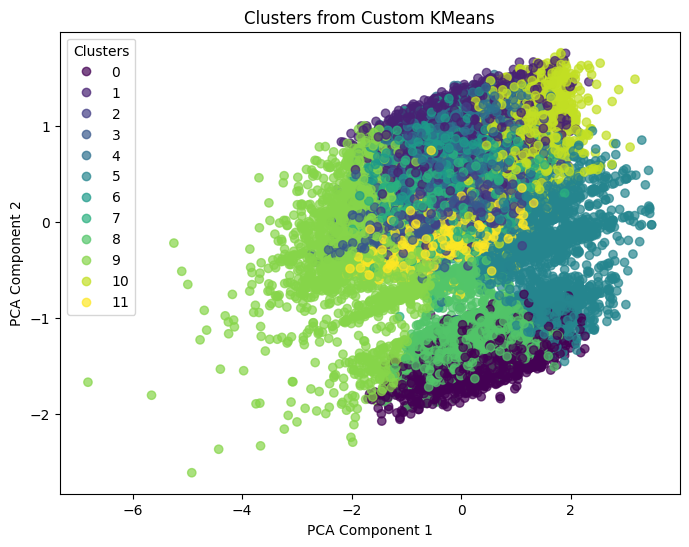

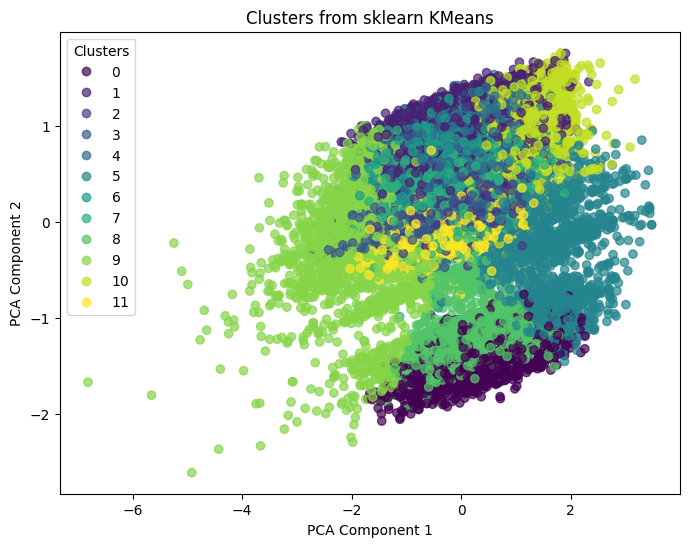

In [13]:
# Initialize the clustering class
clustering = KMeansClustering(train_data, n_clusters=12, random_state=42)

# Run all steps
clustering.run_all()


## **Word2vec**

In [92]:
class Word2Vec:
    def __init__(self, df):
        self.df = df.copy()
        self.genre_sequences = df['Genres'].tolist()  # Tokenized list of genres
        self.model = None
        self.book_embeddings = {}
        self.G = None
        self.sample_size = 1000
        self.seed = 42

    #Train and save a Word2Vec model based on the genre sequences.
    def train_word2vec(self, vector_size=50, window=3, min_count=1, sg=1, epochs=100):
        
        self.model = gensim.models.Word2Vec(
            sentences=self.genre_sequences,
            vector_size=vector_size,
            window=window,
            min_count=min_count,
            sg=sg,
            epochs=epochs,
            seed=self.seed
        )
        self.model.save("genre_word2vec.model")
        print("Word2Vec model trained and saved as 'genre_word2vec.model'.")

    # Precompute and store embeddings for all books in the dataset
    def precompute_book_embeddings(self):
        if self.model is None:
            raise ValueError("Model not trained. Please train model first.")

        self.book_embeddings = {}

        for idx, row in self.df.iterrows():
            genres = row['Genres']
            if isinstance(genres, list):
                # Compute the embedding by averaging genre embeddings
                valid_genres = [genre for genre in genres if genre in self.model.wv]
                if valid_genres:
                    genre_vectors = [self.model.wv[genre] for genre in valid_genres]
                    self.book_embeddings[idx] = np.mean(genre_vectors, axis=0)

        print(f"Precomputed embeddings for {len(self.book_embeddings)} books.")
    

    # Create weighted neighbor graph and visualize it alongside the clustered graph
    def create_and_visualize_graphs(self, k=5, weight_threshold=0.1):
        if not self.book_embeddings:
            raise ValueError("No precomputed embeddings found. Please run precompute_book_embeddings first.")

        # Extract all embeddings
        book_ids = list(self.book_embeddings.keys())
        embeddings_matrix = np.array(list(self.book_embeddings.values()))

        np.random.seed(self.seed)

        # Sample a subset of books
        if self.sample_size < len(book_ids):
            sampled_indices = np.random.choice(len(book_ids), size=self.sample_size, replace=False)
            embeddings_matrix = embeddings_matrix[sampled_indices]
            book_ids = [book_ids[i] for i in sampled_indices]

        # Fit nearest neighbors
        nbrs = NearestNeighbors(n_neighbors=k, metric='cosine').fit(embeddings_matrix)
        distances, indices = nbrs.kneighbors(embeddings_matrix)

        # Create a graph
        self.G = nx.Graph()
        for i, book_id in enumerate(book_ids):
            for neighbor_idx, distance in zip(indices[i], distances[i]):
                neighbor_id = book_ids[neighbor_idx]
                weight = 1 - distance  # Cosine similarity (1 - distance)
                if book_id != neighbor_id and weight >= weight_threshold:
                    self.G.add_edge(book_id, neighbor_id, weight=weight)

        # Initialize the plot with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # 1 row, 2 columns

        # Plot 1: Weighted Neighbor Graph
        pos = nx.spring_layout(self.G, seed=self.seed)  # Use a fixed seed for consistent layout
        edges, weights = zip(*nx.get_edge_attributes(self.G, 'weight').items())
        nx.draw(
            self.G, pos, ax=axes[0], with_labels=False, node_color='lightblue', edge_color=weights,
            width=[w * 2 for w in weights], node_size=50, edge_cmap=plt.cm.Blues
        )
        axes[0].set_title(f"Sampled Weighted Book Neighbor Graph ({len(self.G.nodes)} books out of {self.sample_size})")

        # Plot 2: Clustered Graph
        # Apply Louvain clustering algorithm
        partition = community_louvain.best_partition(self.G, random_state=self.seed)
        num_clusters = max(partition.values()) + 1
        colors = [partition[node] for node in self.G.nodes]
        nx.draw(
            self.G, pos, ax=axes[1], with_labels=False, node_color=colors, edge_color='gray',
            node_size=50, cmap=plt.cm.rainbow
        )
        axes[1].set_title(f"Book Neighbor Graph with {num_clusters} Clusters ({len(self.G.nodes)} books out of {self.sample_size})")

        # Show the combined plot
        plt.show()

    
    def run_all(self):

        # Train Word2Vec model
        self.train_word2vec()

        # Precompute book embeddings
        self.precompute_book_embeddings()

        # Create and visualize graphs
        self.create_and_visualize_graphs()
        

Word2Vec model trained and saved as 'genre_word2vec.model'.
Precomputed embeddings for 25673 books.


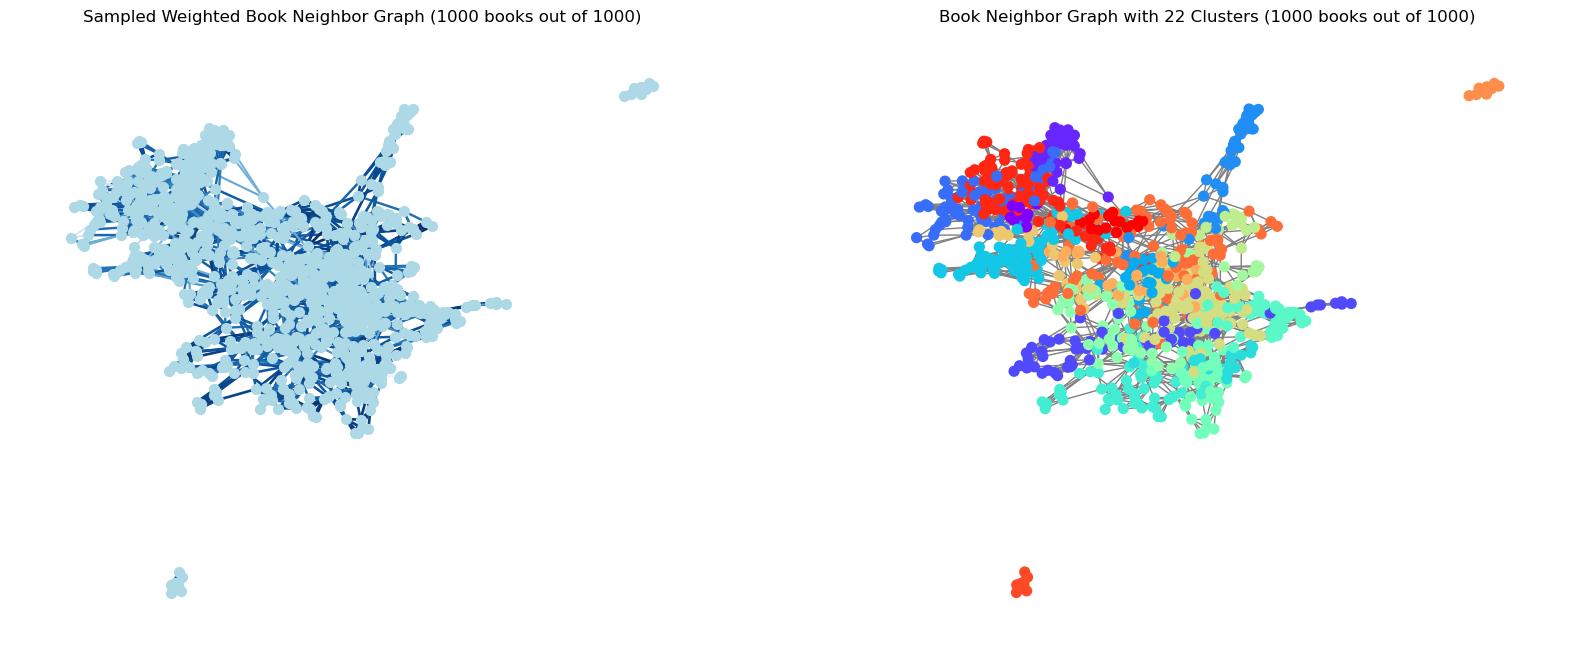

In [93]:
embedded_model = Word2Vec(train_data)
embedded_model.run_all()

## **Recommendation System**

### Using frequent itemsets (Apriori/PCY)

In [50]:
from tqdm import tqdm

def recommend_with_frequent_itemsets(rules: pd.DataFrame, data: pd.DataFrame, algo_type: str):
    """Recommends a single book based on the genres of the input book using either A-Priori or PCY."""

    for row in tqdm(data.itertuples(index=True), total=len(data)): 
        genres = set(row.Genres)
        current_title = row.Title
        recommended_genres = set()
        # Find matching genres using association rule.
        for _, rule in rules.iterrows():
            antecedent = set(rule['antecedents'])
            consequent = set(rule['consequents'])
            if antecedent.issubset(set(genres)):
                recommended_genres.update(consequent)
        # Find books with matching genres.
        data['Intersection Size'] = data['Genres'].apply(lambda x: len(set(x) & set(recommended_genres)))
        recommended_books = data[(data['Title'] != current_title) &  (data['Intersection Size'] > 0)].sort_values(by='Intersection Size', ascending=False)
        if recommended_books.empty:
            data.at[row.Index, f'{algo_type} Recommendations'] = f"No recommendation found for book with title {current_title}"
        else:
            top_recommendation = recommended_books.sort_values(by=['Intersection Size', 'Rating'], ascending=False)['Title'].iloc[0]
            data.at[row.Index, f'{algo_type} Recommendations'] = top_recommendation
        data.drop(columns=['Intersection Size'], inplace=True)

In [ ]:
# Ensure titles are unique. 
unique_titles = test_data.drop_duplicates(subset='Title')
# Ensure genres are unique. 
unique_genres = unique_titles.drop_duplicates(subset='Genres')
# Randomly sample 100 for recommendations. 
sampled_data = unique_genres.sample(n=100, random_state=42) 
# Find book recommendations using A-Priori.
recommend_with_frequent_itemsets(apriori_rules, sampled_data, "A-Priori")
# Find book recommendations using PCY.
recommend_with_frequent_itemsets(pcy_rules, sampled_data, "PCY")


In [ ]:
sampled_data.head(10)

### Using clusters (K-means/DBSCAN)

In [52]:
def recommend_with_clustering(train_data: pd.DataFrame, test_data: pd.DataFrame, algo_type: str):
    """Recommends a single book based on the genres of the input book using K-Means clustering."""

    def genres_to_onehot(genres_list, all_genres, genre_to_index):
        vector = np.zeros(len(all_genres))
        for genre in genres_list:
            idx = genre_to_index.get(genre)
            if idx is not None:
                vector[idx] = 1
        return vector

    # Get all unique genres from both train and test data.
    all_genres = set()
    for genres in train_data['Genres']:
        all_genres.update(genres)
    for genres in test_data['Genres']:
        all_genres.update(genres)
    all_genres = sorted(all_genres)

    genre_to_index = {genre: idx for idx, genre in enumerate(all_genres)}

    # Create one-hot encoded genre vectors.
    train_data['Genre_Vector'] = train_data['Genres'].apply(lambda x: genres_to_onehot(x, all_genres, genre_to_index))
    test_data['Genre_Vector'] = test_data['Genres'].apply(lambda x: genres_to_onehot(x, all_genres, genre_to_index))

    if algo_type == "K-Means":
        clustering_model = KMeans(
            n_clusters=100,
            n_init=1,
            max_iter=300,
            tol=1e-4,
            algorithm='lloyd', 
            random_state=42
        )

    # Assign clusters to the training data.
    train_data['Cluster'] = clustering_model.fit_predict(np.vstack(train_data['Genre_Vector'].values))

    # Predict clusters for the test data.
    test_data['Cluster'] = clustering_model.fit_predict(np.vstack(test_data['Genre_Vector'].values))

    # Compute recommendation
    test_data[f'{algo_type} Recommendations'] = None
    for idx, row in test_data.iterrows():
        current_cluster = row['Cluster']
        current_title = row['Title']
        
        cluster_books = train_data[train_data['Cluster'] == current_cluster]
        recommendations = cluster_books[cluster_books['Title'] != current_title]
        
        top_recommendation = recommendations.sort_values(by='Rating', ascending=False)['Title'].iloc[0]

        if top_recommendation:
            test_data.at[idx, f'{algo_type} Recommendations'] = top_recommendation
        else:
            test_data.at[idx, f'{algo_type} Recommendations'] = "No recommendations found"

    train_data.drop(columns=['Cluster'], inplace=True)
    test_data.drop(columns=['Cluster'], inplace=True)
    train_data.drop(columns=['Genre_Vector'], inplace=True)
    test_data.drop(columns=['Genre_Vector'], inplace=True)

In [53]:
# Ensure titles are unique. 
unique_titles = test_data.drop_duplicates(subset='Title')
# Ensure genres are unique. 
unique_genres = unique_titles.drop_duplicates(subset='Genres')
# Randomly sample 100 for recommendations. 
sampled_data = unique_genres.sample(n=100, random_state=42) 
# Find book recommendations using A-Priori.
recommend_with_clustering(train_data, sampled_data, "K-Means")

In [ ]:
sampled_data.head(50)

,Title,Author,Rating,Genres,K-Means Recommendations
50022,The Lake of Tears,Emily Rodda (Goodreads Author),3.96,"[Fantasy, Fiction, Adventure, Childrens, Young...",The Planetary Omnibus
25173,Secret Origins,James Riley (Goodreads Author),4.31,"[Fantasy, Middle Grade, Adventure, Fiction, Ch...",The Boy At the Back of the Class
13390,The Leveller,Julia Durango,3.67,"[Young Adult, Science Fiction, Romance, Fantas...","J. R. Ward Collection: Black Dagger #1,3,5,6 &..."
21246,The Takeover,T.L. Swan (Goodreads Author),4.59,"[Romance, Contemporary, Contemporary Romance, ...",Remembrance of Things Past: Volume III - The C...
45439,The Naming of the Beasts,Mike Carey (Goodreads Author),4.18,"[Urban Fantasy, Fantasy, Horror, Fiction, Myst...",Lured into Love
3860,Wish You Well,David Baldacci (Goodreads Author),3.99,"[Fiction, Historical Fiction, Mystery, Histori...",Pather Panchali: Song of the Road
47979,One Bite With A Stranger,Christine Warren,3.79,"[Paranormal Romance, Paranormal, Romance, Vamp...",The Complete Liveship Traders Trilogy: Ship of...
40463,Moonshine,Rob Thurman (Goodreads Author),3.98,"[Urban Fantasy, Fantasy, Paranormal, Vampires,...",Almost Heaven
43446,Answering Islam: The Crescent in Light of the ...,"Norman L. Geisler, Abdul Saleeb",3.98,"[Islam, Religion, Christian, Theology, Christi...",Young Woman Personal Progress
19195,Chicken Soup for the Soul: Miracles Happen: 10...,"Jack Canfield, Mark Victor Hansen, Amy Newmark...",3.99,"[Inspirational, Nonfiction]",The Conquering Tide: War in the Pacific Island...


In [ ]:
def recommend_with_word2vec(train_data, test_data):
    """ Recommends a single book for each book in the test dataset based on genre similarity using Word2Vec embeddings. """
    
    # Step 1: Create a Word2Vec instance and train the model
    word2vec_model = Word2Vec(train_data)
    word2vec_model.train_word2vec()
    word2vec_model.precompute_book_embeddings()

    # Extract training embeddings and metadata
    embeddings_matrix = np.array(list(word2vec_model.book_embeddings.values()))
    book_indices = list(word2vec_model.book_embeddings.keys())

    # Step 2: Generate recommendations for test books
    recommendations = []
    for _, test_row in test_data.iterrows():
        test_genres = test_row['Genres']

        try:
            # Compute embedding for the test book
            valid_genres = [genre for genre in test_genres if genre in word2vec_model.model.wv]
            if not valid_genres:
                raise ValueError("No valid genres found in the vocabulary.")

            genre_vectors = [word2vec_model.model.wv[genre] for genre in valid_genres]
            test_embedding = np.mean(genre_vectors, axis=0)

            # Compute cosine similarity between test book and all training books
            similarity_scores = cosine_similarity([test_embedding], embeddings_matrix)[0]

            # Find the most similar book
            most_similar_idx = np.argmax(similarity_scores)
            most_similar_id = book_indices[most_similar_idx]

            # Retrieve the title of the most similar book
            top_recommendation = train_data.loc[most_similar_id, 'Title']
            
        except ValueError:
            # Handle cases where no valid genres or neighbors exist
            top_recommendation = "No recommendations found"

        recommendations.append(top_recommendation)

    # Step 3: Add recommendations to the test data
    test_data['Word2Vec Recommendations'] = recommendations


In [65]:
# Ensure titles are unique. 
unique_titles = test_data.drop_duplicates(subset='Title')
# Ensure genres are unique. 
unique_genres = unique_titles.drop_duplicates(subset='Genres')
# Randomly sample 100 for recommendations. 
sampled_data = unique_genres.sample(n=100, random_state=42) 
# Find book recommendations using A-Priori.
recommend_with_word2vec(train_data, sampled_data)


Word2Vec model trained and saved as 'genre_word2vec.model'.
Precomputed embeddings for 25673 books.


In [67]:
sampled_data.head(10)

,Title,Author,Rating,Genres,Word2Vec Recommendations
50022,The Lake of Tears,Emily Rodda (Goodreads Author),3.96,"[Fantasy, Fiction, Adventure, Childrens, Young...",Return to Del
25173,Secret Origins,James Riley (Goodreads Author),4.31,"[Fantasy, Middle Grade, Adventure, Fiction, Ch...",Minion
13390,The Leveller,Julia Durango,3.67,"[Young Adult, Science Fiction, Romance, Fantas...",The Lab
21246,The Takeover,T.L. Swan (Goodreads Author),4.59,"[Romance, Contemporary, Contemporary Romance, ...",Wild Temptation
45439,The Naming of the Beasts,Mike Carey (Goodreads Author),4.18,"[Urban Fantasy, Fantasy, Horror, Fiction, Myst...",Labyrinth
3860,Wish You Well,David Baldacci (Goodreads Author),3.99,"[Fiction, Historical Fiction, Mystery, Histori...",Tea Cups & Tiger Claws
47979,One Bite With A Stranger,Christine Warren,3.79,"[Paranormal Romance, Paranormal, Romance, Vamp...",Wolf Signs
40463,Moonshine,Rob Thurman (Goodreads Author),3.98,"[Urban Fantasy, Fantasy, Paranormal, Vampires,...",The Last Werewolf
43446,Answering Islam: The Crescent in Light of the ...,"Norman L. Geisler, Abdul Saleeb",3.98,"[Islam, Religion, Christian, Theology, Christi...",Christian Modesty and the Public Undressing of...
19195,Chicken Soup for the Soul: Miracles Happen: 10...,"Jack Canfield, Mark Victor Hansen, Amy Newmark...",3.99,"[Inspirational, Nonfiction]",Chicken Soup for the Soul: From Lemons to Lemo...


### Combine approaches

## **Evaluation and Metrics**

### Word2Vec

In [ ]:
def evaluate_word2vec(train_data, test_data, top_n=10):
    """ Evaluates the Word2Vec model using similarity metrics.
    Calculates metrics between the top_n recommendations vs. the remaining books. """

    # Step 1: Create a Word2Vec instance and train the model
    word2vec_model = Word2Vec(train_data)
    word2vec_model.train_word2vec()
    word2vec_model.precompute_book_embeddings()

    # Extract training embeddings and metadata
    embeddings_matrix = np.array(list(word2vec_model.book_embeddings.values()))

    # Initialize metrics storage
    metrics = []

    # Step 2: Compute similarity metrics for each test book
    for _, test_row in test_data.iterrows():
        test_genres = test_row['Genres']

        # Check valid genres
        valid_genres = [genre for genre in test_genres if genre in word2vec_model.model.wv]
        if not valid_genres:
            print(f"Skipping book '{test_row['Title']}' (no valid genres)")
            metrics.append({
                "Title": test_row['Title'],
                "silhouette_score": None,
                "cohesion": None,
                "separation": None,
                "neighborhood_density": None
            })
            continue

        # Compute embedding for the test book
        genre_vectors = [word2vec_model.model.wv[genre] for genre in valid_genres]
        test_embedding = np.mean(genre_vectors, axis=0)

        # Compute cosine similarity between test book and all training books
        similarity_scores = cosine_similarity([test_embedding], embeddings_matrix)[0]

        # Sort similarities in descending order and get the top_n recommendations
        sorted_indices = np.argsort(similarity_scores)[::-1][:top_n]
        top_k_similarities = similarity_scores[sorted_indices]

        # Calculate metrics
        cohesion = np.mean(top_k_similarities)
        remaining_similarities = similarity_scores[top_n:] if len(similarity_scores) > top_n else np.array([])
        separation = np.mean(remaining_similarities) if remaining_similarities.size > 0 else 0

        silhouette = (separation - cohesion) / max(separation, cohesion) if max(separation, cohesion) != 0 else 0

        top_k_embeddings = embeddings_matrix[sorted_indices]
        density = np.mean(cosine_similarity(top_k_embeddings))

        metrics.append({
            "Title": test_row['Title'],
            "silhouette_score": silhouette,
            "cohesion": cohesion,
            "separation": separation,
            "neighborhood_density": density
        })

    # Step 3: Convert metrics to a DataFrame and return
    metrics_df = pd.DataFrame(metrics)
    return metrics_df


In [79]:
# Ensure titles are unique. 
unique_titles = test_data.drop_duplicates(subset='Title')
# Ensure genres are unique. 
unique_genres = unique_titles.drop_duplicates(subset='Genres')
# Randomly sample 100 books for evaluation.
sampled_data = unique_genres.sample(n=100, random_state=42)
# Evaluate similarity metrics
metrics_df = evaluate_word2vec(train_data, sampled_data, top_n=10)
# Display metrics
metrics_df.head(10)

Word2Vec model trained and saved as 'genre_word2vec.model'.
Precomputed embeddings for 25673 books.


,Title,silhouette_score,cohesion,separation,neighborhood_density
0,The Lake of Tears,-0.438869,0.984817,0.552612,0.977496
1,Secret Origins,-0.428441,0.965090,0.551606,0.975364
2,The Leveller,-0.408367,0.956185,0.565711,0.975033
3,The Takeover,-0.502683,0.989000,0.491847,0.985387
4,The Naming of the Beasts,-0.485115,0.966855,0.497819,0.962812
5,Wish You Well,-0.382973,0.956881,0.590422,0.941359
6,One Bite With A Stranger,-0.490528,0.987747,0.503230,0.989365
7,Moonshine,-0.476878,0.986492,0.516055,0.988028
8,Answering Islam: The Crescent in Light of the ...,-0.617747,0.958993,0.366578,0.966919
9,Chicken Soup for the Soul: Miracles Happen: 10...,-0.644740,0.914315,0.324820,0.897308
